In [ ]:
!pip install imblearn

In [ ]:
## download libraries
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from keras.utils import to_categorical
from PIL import ImageFile
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
ImageFile.LOAD_TRUNCATED_IMAGES = True
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf
import os


# **A CONVOLUTIONAL NEURAL NETWORK MODEL FOR CLASSIFYING DAMAGE**
by Devin Guevara, Muqtader Omari, Adam Kauffman


### **BACKGROUND & MOTIVATION**
Classifying images of damage shared on social media serves two  purposes. Firstly, it aids in automatically filtering traumatic content depicting damage from minors under parental controls. Secondly, it enables the automatic detection of images showcasing catastrophic damage for news reporting and accelerated emergency response. Additionally, models like the one we've built here could be instrumental to researchers who need vast amounts of data to study how information disseminates through social media.


### **DATASET DESCRIPTION**
[The Multimodal Damage Identification for Humanitarian Computing Dataset](https://archive.ics.uci.edu/dataset/456/multimodal+damage+identification+for+humanitarian+computing) comprises 5879 labeled images (640 x 640 RGB) from social media and their captions. The images are separated into different folders, and they are all jpegs. We noticed that these images’ labels are mutually exclusive, meaning they do not have two labels at once.
5879 images with these different labels:  
1. “Damaged infrastructure”
2. “Damaged nature”
3. “Damaged humans”
4. “Fires”
5. “Floods”
6. “No Damage”




## **Visualizaton & Exploratory Data Analysis**


#### Average Image and Color Analysis:
The average images across categories reveal a muted color palette with variations, potentially due to the averaging process.
'Fires' and 'flood' categories show distinct average color tones that could be characteristic of their respective types of damage.
File Size Distribution:



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

project_dir = '/content/drive/MyDrive/CS 109b Final Project'

data_dir = project_dir + '/data/multimodal'

categories = ['damaged_infrastructure', 'damaged_nature', 'fires', 'flood', 'human_damage', 'non_damage']
data = []
for category in categories:
    category_image_dir = os.path.join(data_dir, category, 'images')
    files = os.listdir(category_image_dir)
    for file in files:
        if file.endswith('.jpg'):
            file_path = os.path.join(category_image_dir, file)
            data.append({'file_path': file_path, 'label': category})

df = pd.DataFrame(data)
print(df.head())

                                           file_path                   label
0  /content/drive/MyDrive/CS 109b Final Project/d...  damaged_infrastructure
1  /content/drive/MyDrive/CS 109b Final Project/d...  damaged_infrastructure
2  /content/drive/MyDrive/CS 109b Final Project/d...  damaged_infrastructure
3  /content/drive/MyDrive/CS 109b Final Project/d...  damaged_infrastructure
4  /content/drive/MyDrive/CS 109b Final Project/d...  damaged_infrastructure


### Random sample Rendering
In the following code we sample some pictures of every category in order to get an understanding of the kinds of images in every category.

Displaying images for category: damaged_infrastructure


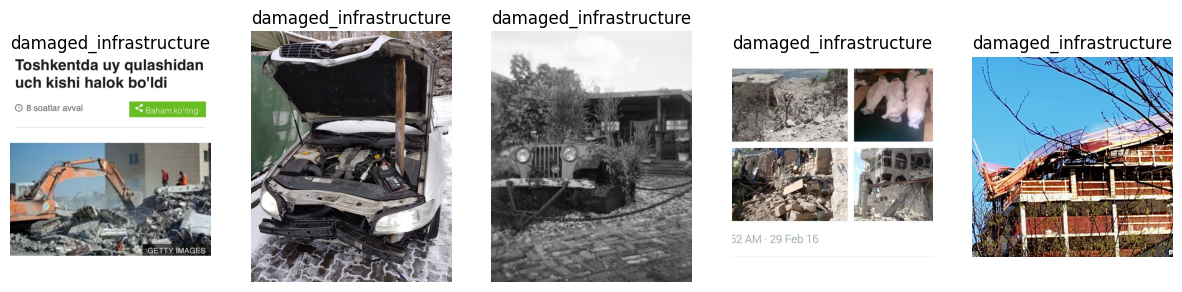

Displaying images for category: damaged_nature


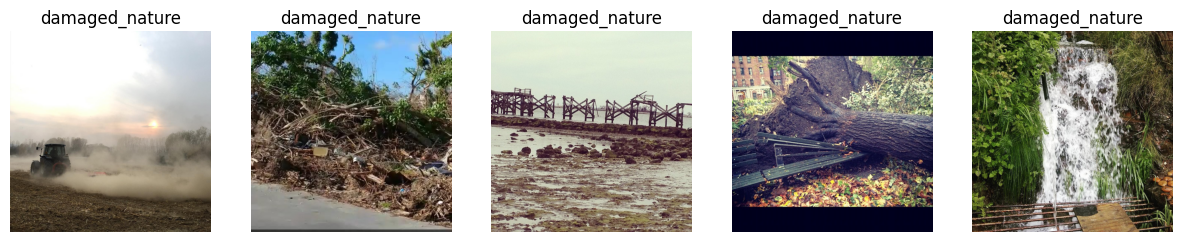

Displaying images for category: fires


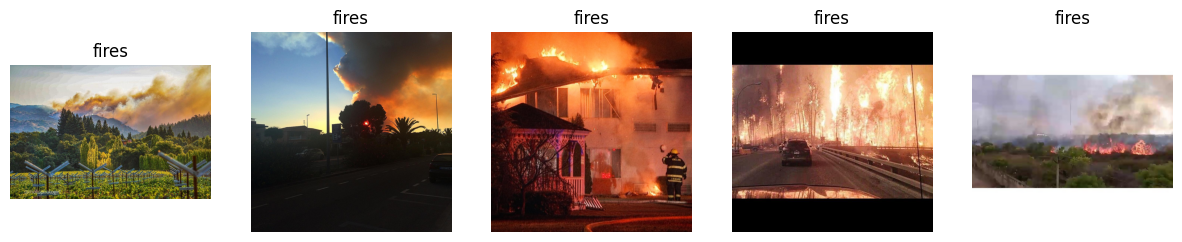

Displaying images for category: flood


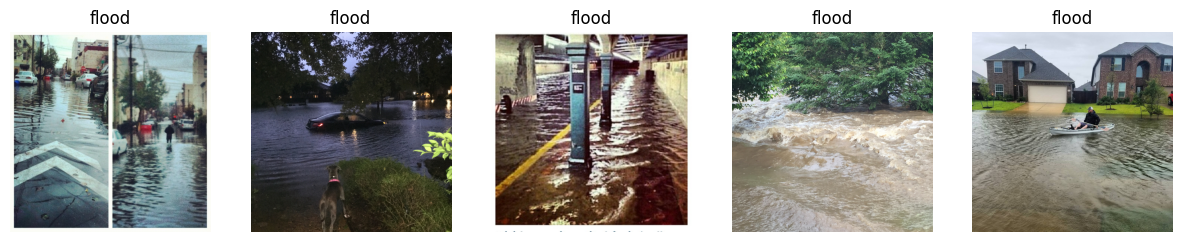

Displaying images for category: human_damage


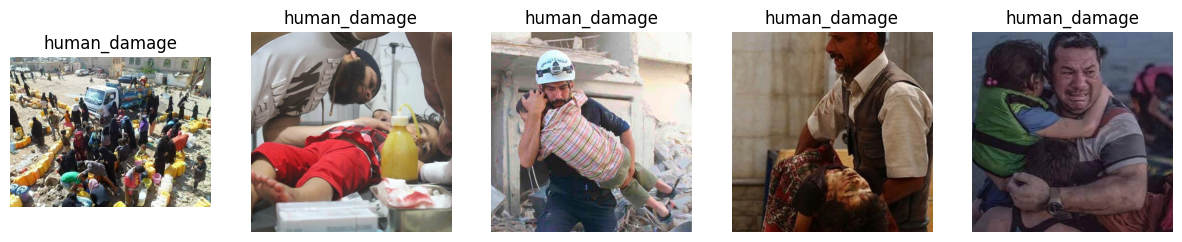

Displaying images for category: non_damage


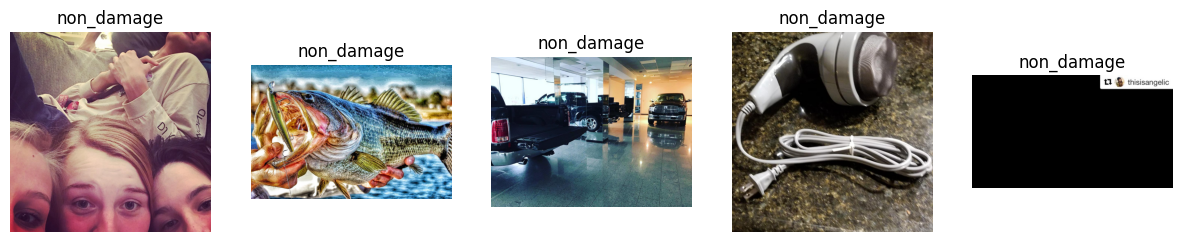

In [ ]:
# Show some sample images
def display_images(dataframe, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
    for ax, row in zip(axes, dataframe.sample(num_images).iterrows()):
        img_path = row[1]['file_path']
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(row[1]['label'])

for category in categories:
    print(f"Displaying images for category: {category}")
    display_images(df[df['label'] == category])
    plt.show()

### Class Distribution and Balance:
The dataset suffers from a significant class imbalance with an overrepresentation of 'non_damage' images and a scarcity of 'human_damage' images, suggesting potential bias in model training towards the more frequent classes. Techniques like the Synthetic Minority Over-sampling Technique (SMOTE) will be considered to balance the class distribution.


label
non_damage                2972
damaged_infrastructure    1431
damaged_nature             515
flood                      385
fires                      349
human_damage               240
Name: count, dtype: int64


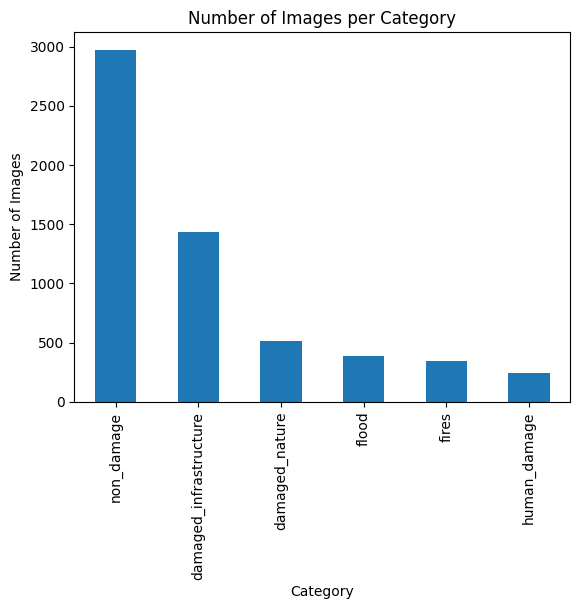

In [ ]:
# Count number of images in each category
category_counts = df['label'].value_counts()
print(category_counts)

category_counts.plot(kind='bar')
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image
import pandas as pd

def check_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
        return file_path, None
    except (IOError, SyntaxError) as e:
        return file_path, e

# Find corrupted images (there are none, so the code is commented out now)
corrupted_files = []
# with ThreadPoolExecutor() as executor:
#     # Map the check_image function to each file path
#     future_to_file = {executor.submit(check_image, row['file_path']): row for index, row in df.iterrows()}
#     for future in as_completed(future_to_file):
#         file_path, error = future.result()
#         if error:
#             corrupted_files.append(file_path)

print(f"Number of corrupted files: {len(corrupted_files)}")

Number of corrupted files: 0


### Pixel Intensity Characteristics:
In the following cells we analyzed the differences and similarities between the images' pixel intensity.

- 'fires' pixel intensities seem to be skewed right, meaning most of the images' pixels for this category are low intensity. High red channel intensity counts seem to be higher than for blue and green as well.
- 'Damaged_nature', 'flood', and 'Non-damage' categories have a balanced distribution of color intensities, with blue hints in flood images.
- 'Human_damage' images exhibit a varied color distribution, indicative of diverse image content. It also demonstrates a higher intensity across color channels relative to other categories.


### Saturation and Exposure:
The presence of saturation in images is highlighted by spikes at maximum intensity values, suggesting potential overexposure or the presence of artificial light or elements in the images.

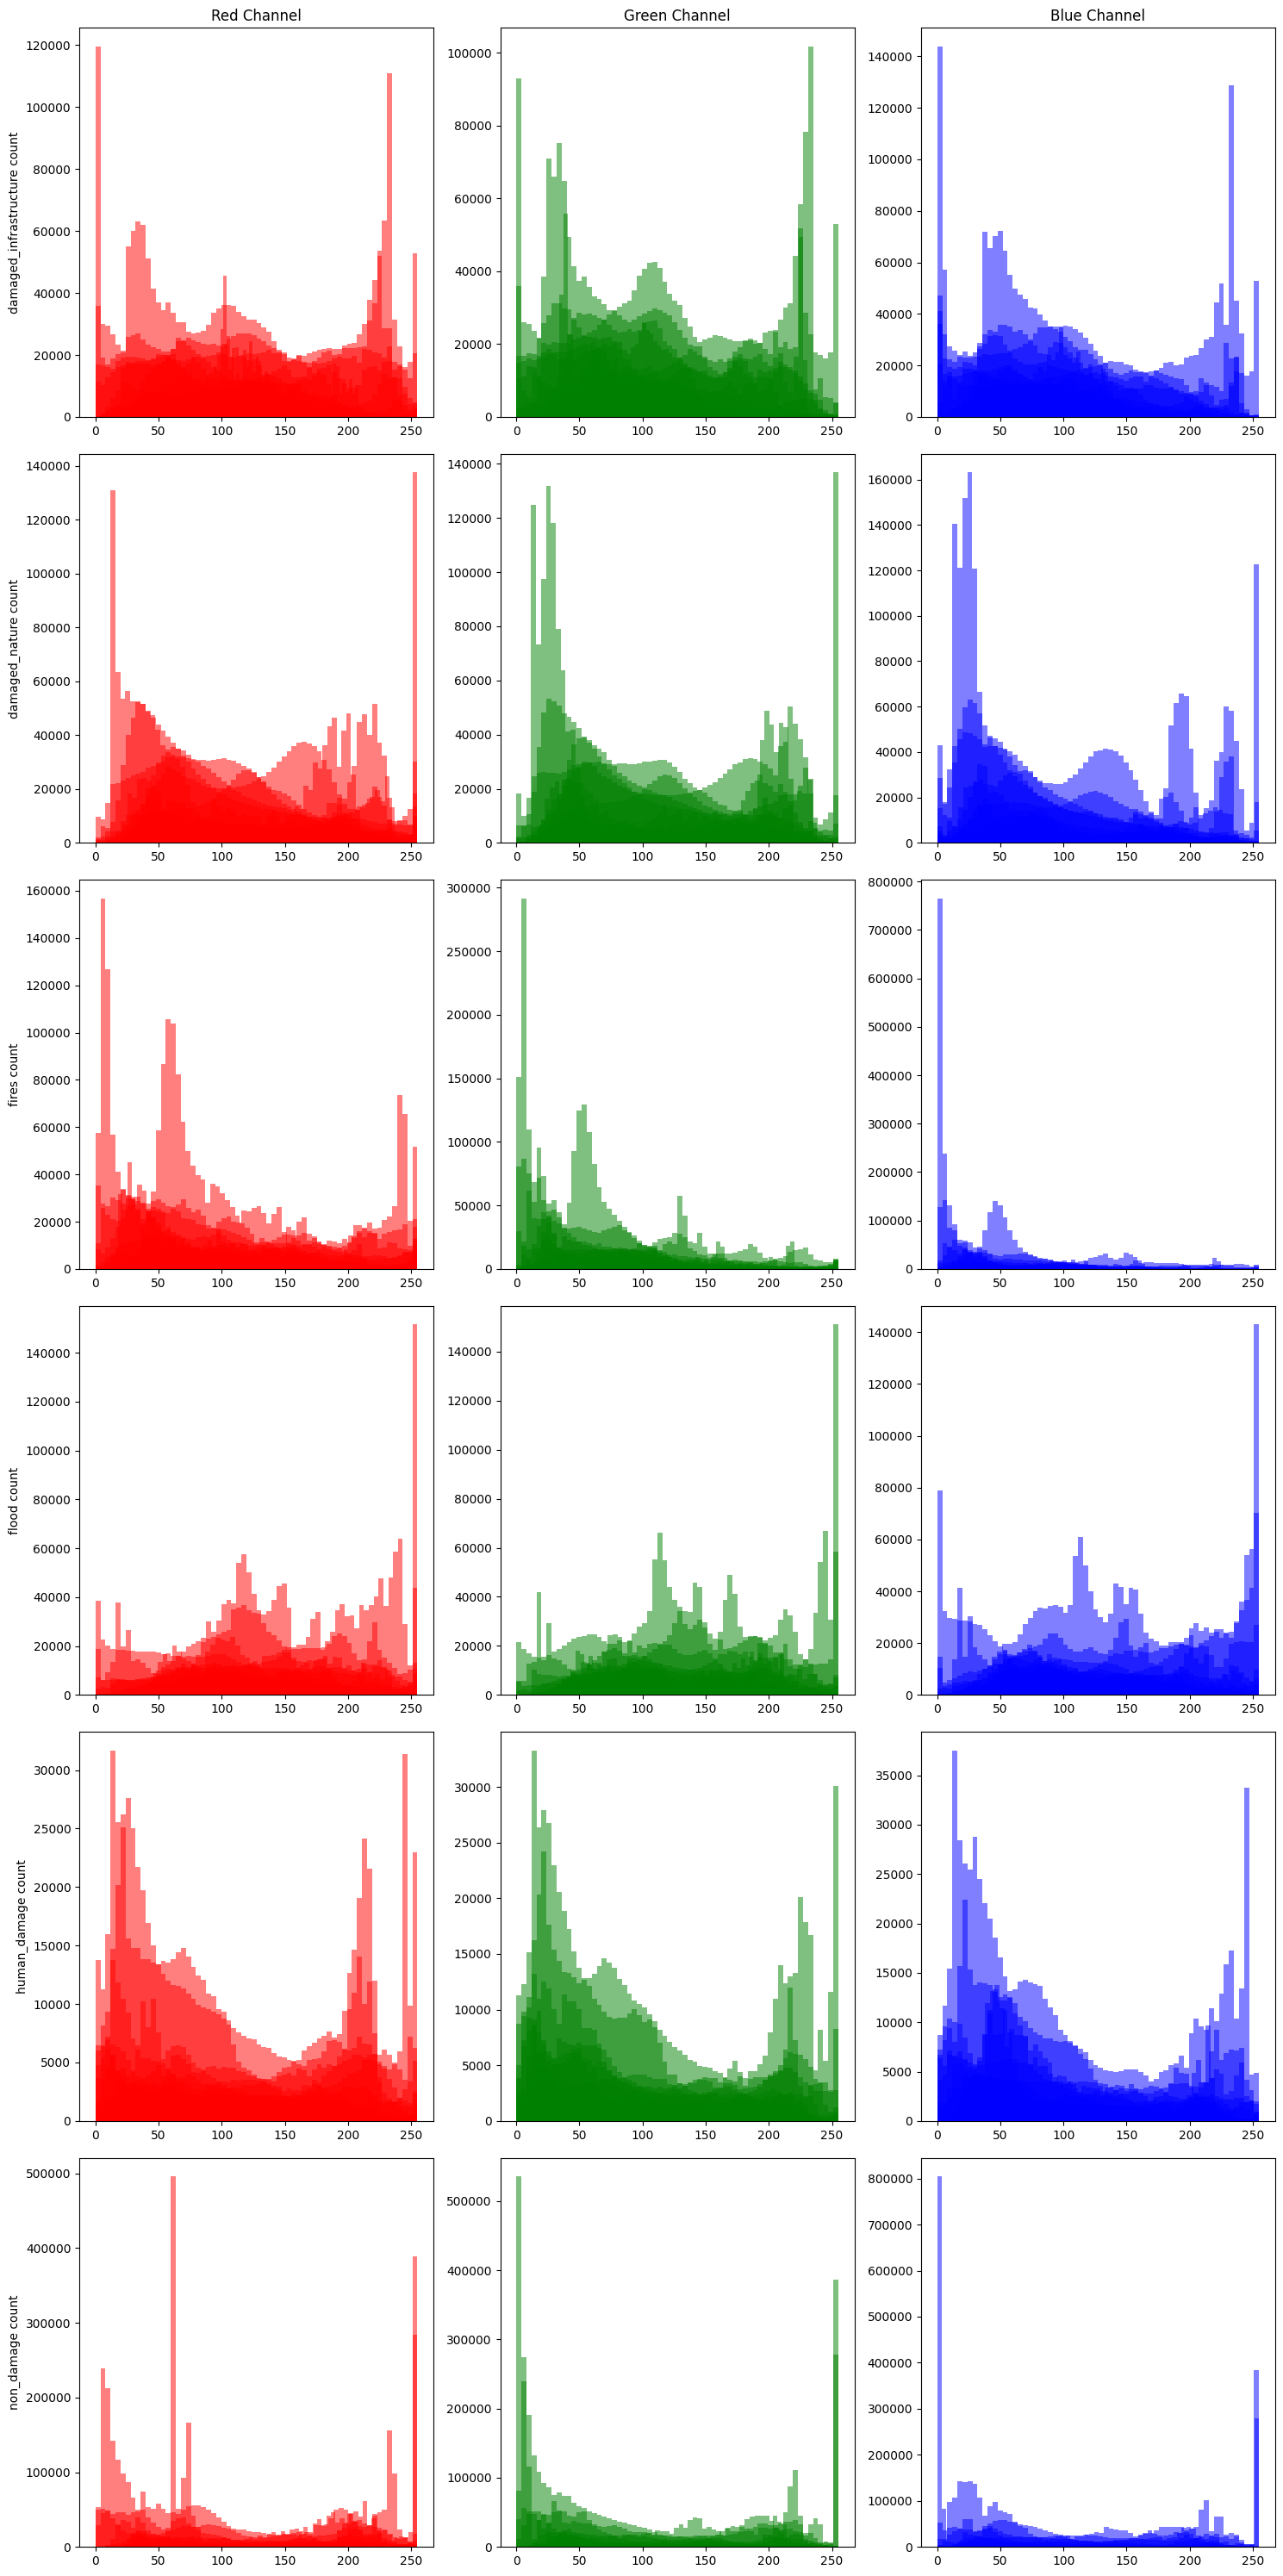

In [ ]:
from PIL import Image

# Display the distribution of pixel intensities in each category
def plot_pixel_intensity_histograms(df, categories, sample_size=10):
    fig, axs = plt.subplots(len(categories), 3, figsize=(15, 5 * len(categories)))

    for i, category in enumerate(categories):
        sample_images = df[df['label'] == category].sample(sample_size)['file_path']
        for img_path in sample_images:
            img = Image.open(img_path)
            pixels = np.array(img)
            for j in range(3):  # Assuming RGB images
                axs[i, j].hist(pixels[:, :, j].ravel(), bins=64, color=['r','g','b'][j], alpha=0.5)
        axs[i, 0].set_ylabel(f"{category} count")

    for ax, color in zip(axs[0], ['Red Channel', 'Green Channel', 'Blue Channel']):
        ax.set_title(color)

    plt.tight_layout()
    plt.show()

plot_pixel_intensity_histograms(df, categories)

### Average Color Analysis:
'Fires' category shows a reddish undertone that could be characteristic of the redness of fires. Other categories are very gray and don't exhibit any strong undertones.


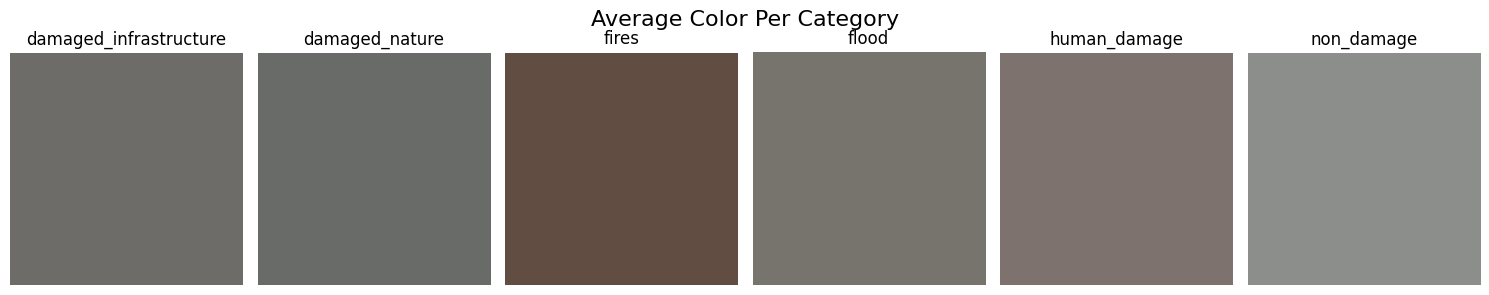

In [14]:
import random
#randomly sampling 20 instead because takes too long to run
def plot_mean_color_per_category(df, categories):
    fig, axs = plt.subplots(1, len(categories), figsize=(15, 3))
    for ax, category in zip(axs, categories):
        sample_images = df[df['label'] == category]['file_path']
        sample_images = random.sample(list(sample_images), min(20, len(sample_images)))
        mean_colors = []
        for img_path in sample_images:
            try:
                img = Image.open(img_path).convert('RGB')
                np_img = np.array(img)
                mean_colors.append(np.mean(np_img, axis=(0, 1)))
            except (IOError, SyntaxError, ValueError) as e:
                print(f"Skipping corrupted image: {img_path}")
        if mean_colors:
            mean_color = np.mean(mean_colors, axis=0).astype(np.uint8)
            ax.imshow(np.full((10, 10, 3), mean_color, dtype=np.uint8))
            ax.set_title(category)
        else:
            ax.text(0.5, 0.5, 'No valid images', horizontalalignment='center', verticalalignment='center')
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle('Average Color Per Category', fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_mean_color_per_category(df, categories)

### File Sizes
The histograms of image file sizes indicate a right-skewed distribution, with most images having smaller file sizes, and a few larger files, possibly due to higher resolution or detail.
The distribution of file sizes by category is also skewed, with the 'non_damage' category having a wide range of file sizes, potentially affecting storage and computational requirements.
The dataset displays both a class imbalance and a variety of pixel intensity and color characteristics that are specific to each category of damage. These features must be considered in the preprocessing phase to ensure the resulting model is not biased and can generalize well across all types of damage. Moreover, the skew in file sizes suggests that normalization of image dimensions could be beneficial for consistent model input.


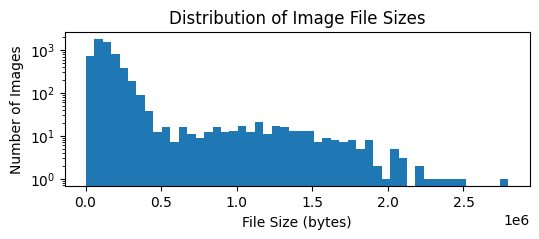

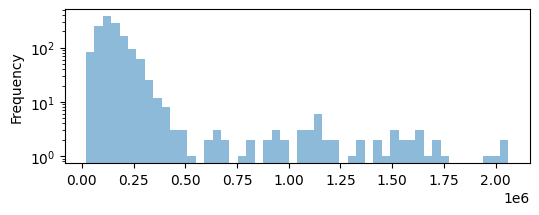

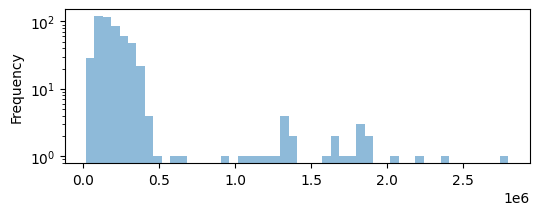

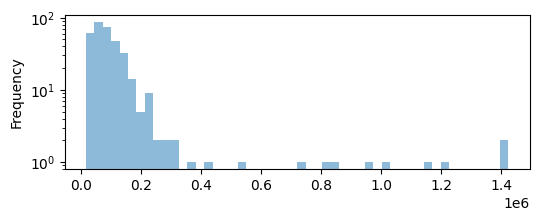

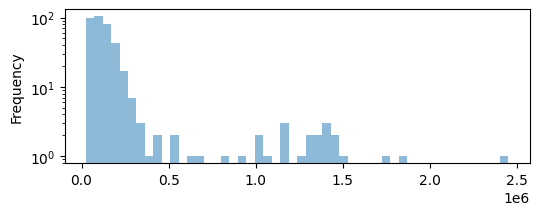

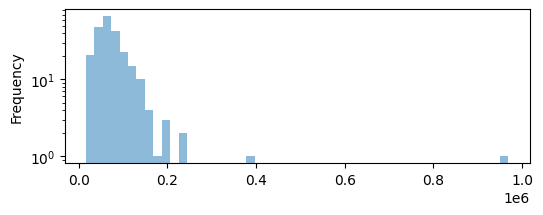

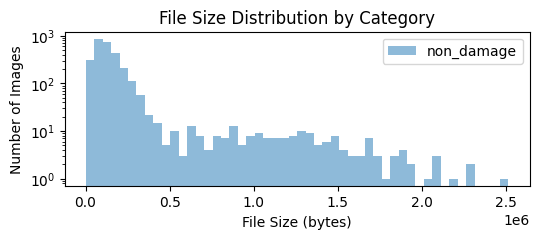

In [ ]:
df['file_size'] = df['file_path'].apply(lambda x: os.path.getsize(x))

plt.figure(figsize=(6, 2))
df['file_size'].plot(kind='hist', bins=50, logy=True)
plt.title('Distribution of Image File Sizes')
plt.xlabel('File Size (bytes)')
plt.ylabel('Number of Images')
plt.show()
for category in categories:
    plt.figure(figsize=(6, 2))
    df[df['label'] == category]['file_size'].plot(kind='hist', bins=50, logy=True, alpha=0.5, label=category)

plt.title('File Size Distribution by Category')
plt.xlabel('File Size (bytes)')
plt.ylabel('Number of Images')
plt.legend()
plt.show()

## **Insights**
Our exploratory data analysis led to several very important observations about our data. Most salient among them is that our dataset contains extremely graphic images of human damage, which compelled us to make important ethical considerations. For instance, while we believe our model could do good by helping emergency response teams to identify catastrophic events as images of them are uploaded to social media, we must take steps to ensure our model classifies human damage at a similar rate for all human groups. We also recognize that the images used to train our models were most likely not taken with informed consent, so we plan to be completely transparent about this if we were to publish our model.

We also realize there are very many examples of catastrophic events that our dataset does not include, such as landslides, sinkholes, heatwaves, snow storms, and much more. This means that our model cannot be trusted to identify all catastrophic events, and we plan to be extremely transparent about this.


## **Revised Project Question & Problem Statement**
Based on our insights from our exploration, we propose the following question:

Can we build a sufficiently unbiased and ethical model that correctly identifies human damage, infrastructure damage, nature damage, flooding, fires? Our model should classify and return only the most salient type of damage (or lack thereof) found in an image, since there are no photos which are labeled with more than one kind of image.


## **Baseline Model**
We utilized` InceptionV3`, a  pre-trained Convolutional Neural Networks (CNN) as a starting point. Fine-tuning this existing model allowed us to take advantage of transfer learning, which can be particularly effective when dealing with limited data in certain categories. Another reason we decided to use InceptionV3 is because it is a strong performing, proven, and readily available baseline that has been trained on a vast number of images.

In particular, we:
- Imported InceptionV3 from the keras library
- Added fully connected output, Global Average Pooling, and dense layers to predict the 6 classes
- Applied some simple data augmentation techniques to rescale and rotate training images
- Trained the new dense layers while keeping the convolutional layers frozen




### Dynamic Data Processing, Augmentation, and Training Pipeline

In [18]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from keras.utils import to_categorical
from PIL import ImageFile
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Create ImageDataGenerators for training and validation
train_val_df, test_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=109)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df['label'], random_state=109)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, #okay actually we are normalizing our input right here
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create data loaders
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4771 validated image filenames belonging to 6 classes.
Found 531 validated image filenames belonging to 6 classes.


### Training

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# load in the pre-trained model without the dense layers
base_model = InceptionV3(weights='imagenet', include_top=False)

# add new fully connected layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# freeze convolutional layers and just train the new dense layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=3,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/3
150/150 [==============================] - 230s 2s/step - loss: 0.8518 - accuracy: 0.7418 - val_loss: 0.5690 - val_accuracy: 0.8211
Epoch 2/3
150/150 [==============================] - 211s 1s/step - loss: 0.5031 - accuracy: 0.8227 - val_loss: 0.4559 - val_accuracy: 0.8531
Epoch 3/3
150/150 [==============================] - 241s 2s/step - loss: 0.5004 - accuracy: 0.8212 - val_loss: 0.4484 - val_accuracy: 0.8456


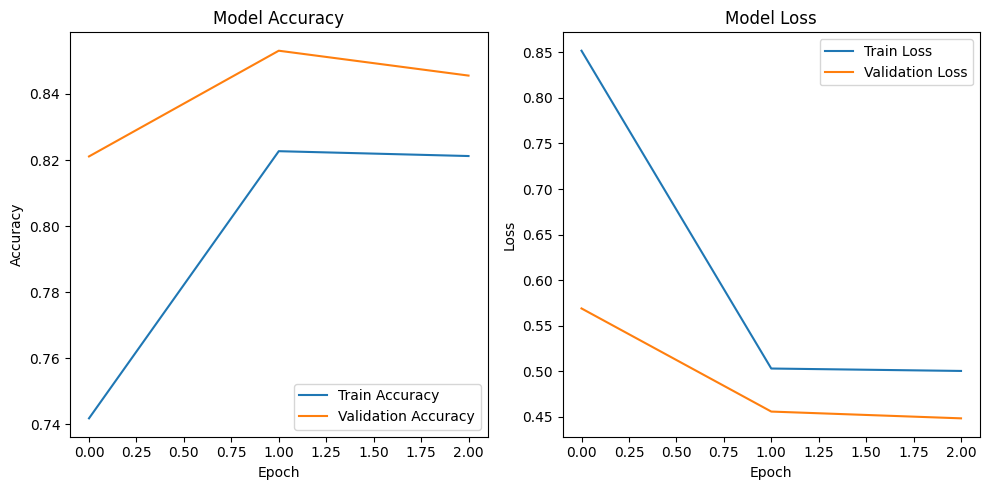

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# save model
model_path = project_dir + '/models/inception_v3_finetuned_1.keras'
#model.save(model_path)

In [16]:
import keras

# load model
model_path = project_dir + '/models/inception_v3_finetuned_1.keras'
model = keras.models.load_model(model_path)
model.compile(optimizer='adam', loss='categorical_crossentropy', steps_per_execution=10,  metrics=['accuracy'])

### Test Set Accuracy about 87%

In [19]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# # Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 590 validated image filenames belonging to 6 classes.
19/19 [==============================] - 116s 6s/step - loss: 0.3636 - accuracy: 0.8763
Test Loss: 0.36359623074531555
Test Accuracy: 0.8762711882591248


### Performance by Class

Our baseline inception model seems to have performed about 25% worse when classifying "damaged nature" and "flood" images.

19/19 [==============================] - 64s 3s/step


Text(37.722222222222214, 0.5, 'Accuracy Score')

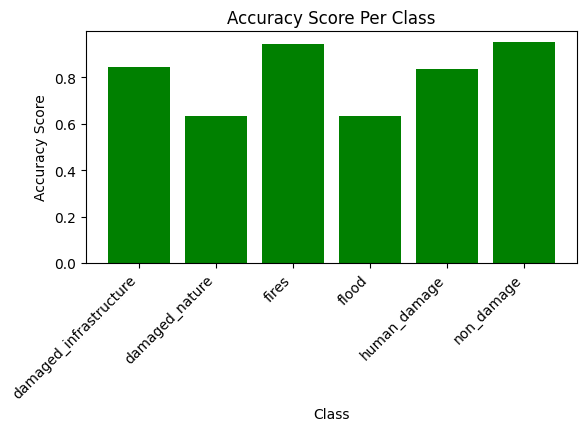

In [ ]:
# Make predictions on the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

#create the class accuracies object
class_names = test_generator.class_indices.keys()
class_accuracies = {}

#iterate through the class names
for class_name in class_names:
  #get the total number of times you predicted the class_name correctly
  class_idx = test_generator.class_indices[class_name]
  class_indices =  [i for i, value in enumerate(y_true_classes) if value == class_idx]
  class_y_true = [y_true_classes[i] for i in class_indices]

  #get the total number of times you predicteed the clase name
  class_y_pred = [y_pred_classes[i] for i in class_indices]

  #get the accuracy and append it to the dictionary object
  class_accuracy = accuracy_score(class_y_true, class_y_pred)
  class_accuracies[class_name] = class_accuracy

plt.figure(figsize=(6,4))
plt.bar(class_accuracies.keys(), class_accuracies.values(), color = 'green')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.title("Accuracy Score Per Class")
plt.xlabel("Class")
plt.ylabel("Accuracy Score")

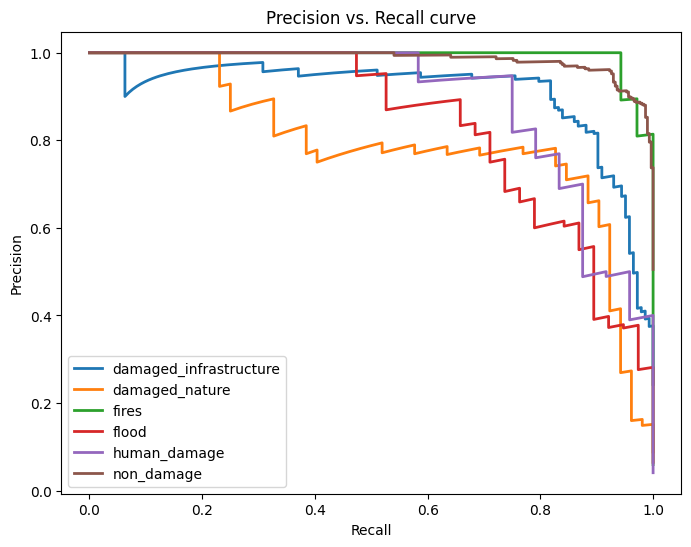

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Plot precision vs recall curves
test_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
y_test_bin = label_binarize(test_labels, classes=range(len(class_labels)))
precision = dict()
recall = dict()
thresholds = dict()

for i, class_name in enumerate(class_labels):
    precision[class_name], recall[class_name], thresholds[class_name] = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])

plt.figure(figsize=(8, 6))
for class_name in class_labels:
    plt.plot(recall[class_name], precision[class_name], lw=2, label=class_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

### Baseline Model Results
The Precision vs. Recall curve and the Accuracy Score Per Class graph together provide a comprehensive evaluation of the model's performance across different damage categories. The Precision vs. Recall curve indicates that while the model performs well for "non_damage" with high precision over a broad recall range, it exhibits a significant decline in precision for "damaged_nature" as recall increases, which may be indicative of issues like class imbalance or more challenging class distinctions. Meanwhile, the Accuracy Score Per Class graph reveals a disparity in the model's ability to classify "damaged nature" and "flood" images compared to other categories, with a notably lower performance by approximately 25%. These insights suggest that while the model has learned to recognize some damage types effectively, it struggles with others, particularly where the training data may be limited or less varied. To improve the model's performance, especially for the underperforming classes, strategies such as SMOTE for oversampling and targeted data augmentation could be employed to provide a more balanced training dataset and encourage the model to learn more generalizable features for those classes.

Overall, our baseline InceptionV3 model achieved an 87% accuracy score for all classes combined! We believe the strategies mentioned above will help us increase this even more.


## **Final Model**

- We finetunes weights in the last few convolutional layers of the base model that we trained. This will allow us to tailor the weights for our purposes even further.
- Oversampled from and augment primarily the “flood” and “nature damage” classes to improve accuracy scores for those kinds of images since they are underepresented. We added rotation, flip, random crop and resizing, color jittering, shear, elastic, and cutout distortions for augmentation.
- Attempted to train for longer than 3 epochs.
- Considered Potentially tweak the loss function to provide extra emphasis on the damage / no damage distinction along with classifying damage (better to flag that damage occurred but misclassify it than to miss damage altogether).


## Resampling Minority Classes (Equal Distribution among minority classses only)

In [ ]:
from sklearn.utils import resample

# Count non damage
majority_class_count = len(train_df[train_df['label'] == 'damaged_infrastructure'])
balanced_df = pd.DataFrame(columns=train_df.columns)

# Resample to balance minority classes
for class_label in train_df['label'].unique():
    if class_label ==  'non_damage':
        balanced_df = pd.concat([balanced_df, train_df[train_df['label'] == class_label]])
    elif class_label == 'damaged_infrastructure':
        balanced_df = pd.concat([balanced_df, train_df[train_df['label']== class_label]])
    else:
        minority_class_samples = train_df[train_df['label'] == class_label]
        minority_upsampled = resample(minority_class_samples,
                                       replace=True,
                                       n_samples=majority_class_count,
                                       random_state=109)
        balanced_df = pd.concat([balanced_df, minority_upsampled])

balanced_df = balanced_df.sample(frac=1, random_state=109)

label
non_damage                2406
flood                     1159
damaged_nature            1159
damaged_infrastructure    1159
human_damage              1159
fires                     1159
Name: count, dtype: int64


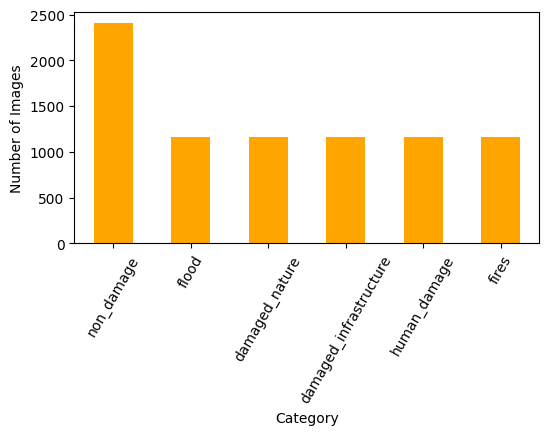

In [ ]:
# Visualize the balanced distribution
category_counts = balanced_df['label'].value_counts()
print(category_counts)

fig, axes = plt.subplots(1, figsize=(6, 3))
category_counts.plot(kind='bar', color = "orange")
plt.xticks(rotation = 60)
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()

## Data Pipeline
Added brightness and color distortions for augmentation

In [ ]:
# Create ImageDataGenerators for training and validation
train_val_df_2, test_df_2 = train_test_split(balanced_df, test_size=0.1, stratify=balanced_df['label'], random_state=109)
train_df_2, val_df_2 = train_test_split(train_val_df_2, test_size=0.1, stratify=train_val_df_2['label'], random_state=109)

train_datagen_2 = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    # Additional data augmentation
    brightness_range = (0.7, 1.3),
    channel_shift_range = 10,
    fill_mode='nearest'
)

val_datagen_2 = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create data loaders
train_generator_2 = train_datagen_2.flow_from_dataframe(
    dataframe=train_df_2,
    x_col='file_path',
    y_col='label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_generator_2 = val_datagen_2.flow_from_dataframe(
    dataframe=val_df_2,
    x_col='file_path',
    y_col='label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6642 validated image filenames belonging to 6 classes.
Found 738 validated image filenames belonging to 6 classes.


## Finetune convolutional layers

In [20]:
# Recompile the model with a low learning rate
from keras.optimizers import Adam

#unfreeze last convolutional layer
for layer in reversed(model.layers):
    if isinstance(layer, keras.layers.Conv2D):
        layer.trainable = True
        break

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', steps_per_execution=10,  metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, None, None, 32)       96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, None, None, 32)       0         ['batch_normalization_94

### Attempted to train but took far too long for the first epoch, making it evident that we need greater computational resources than those at our disposal.

In [ ]:


history_2 = model.fit(
    train_generator_2,
    steps_per
    _epoch=len(train_generator_2),
    epochs=2,
    validation_data=val_generator_2,
    validation_steps=len(val_generator_2)
)

Epoch 1/2
 10/208 [>.............................] - ETA: 2:28:35 - loss: 0.5354 - accuracy: 0.8125

KeyboardInterrupt: 

In [ ]:
# Make predictions on the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

#create the class accuracies object
class_names = test_generator.class_indices.keys()
class_accuracies = {}

#iterate through the class names
for class_name in class_names:
  #get the total number of times you predicted the class_name correctly
  class_idx = test_generator.class_indices[class_name]
  class_indices =  [i for i, value in enumerate(y_true_classes) if value == class_idx]
  class_y_true = [y_true_classes[i] for i in class_indices]

  #get the total number of times you predicteed the clase name
  class_y_pred = [y_pred_classes[i] for i in class_indices]

  #get the accuracy and append it to the dictionary object
  class_accuracy = accuracy_score(class_y_true, class_y_pred)
  class_accuracies[class_name] = class_accuracy

plt.figure(figsize=(6,4))
plt.bar(class_accuracies.keys(), class_accuracies.values(), color = 'green')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.title("Accuracy Score Per Class")
plt.xlabel("Class")
plt.ylabel("Accuracy Score")

In [ ]:
# save model
model_path = project_dir + '/models/inception_v3_finetuned_2.keras'
model.save(model_path)

## Results & Conclusion
Pre-trained InceptionV3 is well suited to classifying damage in images, but thoroughly training it required much more computational resources than we expected. We unfortunately could not finish training this model, especially since we could not configure the co-lab GPU/TPU to meet the needs of training our fine-tuned model.

Future work could include:
- Model deployment
- Integration with social media through existing APIs
- Develop and integrate augmentation model for improved accuracy
- Make this deployed model widely available
- Collect damage data on social media and publish it for research